In [4]:
%matplotlib inline
! python example.py 

/n/home12/sgossage/.conda/envs/ANA_192/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


/n/home12/sgossage/.conda/envs/ANA_192/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Reading in: /n/conroyfs1/sgossage/MIST_grids/MIST_v1.0/output/feh_p0.15_afe_p0.0_vvcrit0.5/isochrones/MIST_v1.0_feh_p0.15_afe_p0.0_vvcrit0.5_full.iso


Reading in: /n/conroyfs1/sgossage/MIST_grids/MIST_v1.0/output/feh_p0.15_afe_p0.0_vvcrit0.5/isochrones/MIST_v1.0_feh_p0.15_afe_p0.0_vvcrit0.5_full.iso


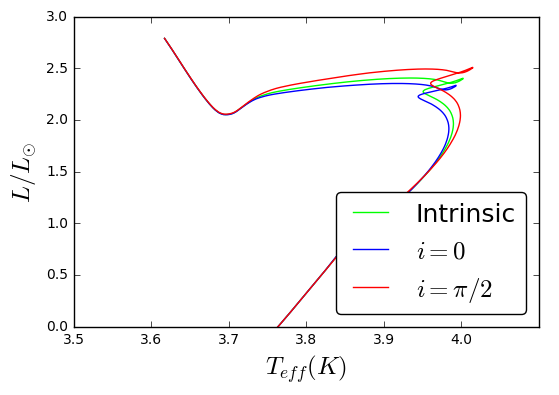

In [150]:
# Aaron Dotter's grav. darkening code:
from pylab import *
from scipy.interpolate import RectBivariateSpline
from plot_routine.read_mist_models import *

#this creates two 2-D interpolants for C_T and C_L
def create_interpolants(npz):
    data=load(npz)
    C_L=data['C_L']
    C_T=data['C_T']
    omega=data['omega']
    inclination=data['inclination']
    f_T=RectBivariateSpline(y=omega, x=inclination, z=C_T)
    f_L=RectBivariateSpline(y=omega, x=inclination, z=C_L)
    return f_T, f_L

#read in an isochrone set
fn='/n/conroyfs1/sgossage/MIST_grids/MIST_v1.0/output/feh_p0.15_afe_p0.0_vvcrit0.5/isochrones/MIST_v1.0_feh_p0.15_afe_p0.0_vvcrit0.5_full.iso'
x=ISO(fn) #ISO('MIST_v1.0_feh_p0.00_afe_p0.0_vvcrit0.4_full.iso')

f_T, f_L = create_interpolants('GD.npz')

#choose one isochrone for demonstration
iso=x.isos[x.age_index(8.5)]
i=squeeze(where( (iso['EEP']<808) & (iso['EEP']>202) ))
iso=iso[i]
omega=iso['surf_avg_omega_div_omega_crit']
T=pow(10,iso['log_Teff'])
L=pow(10,iso['log_L'])

figure(1)
#plot the intrinsic model quantities
plot(log10(T),log10(L), color='Lime', label='Intrinsic')

#plot the gravity-darkened models at i=0, "edge-on"
C_T=f_T.ev(yi=omega, xi=zeros(len(omega)))
C_L=f_L.ev(yi=omega, xi=zeros(len(omega)))
plot(log10(C_T*T), log10(C_L*L), color='Blue', label=r'$i=0$')

#plot the gravity-darkened models at i=90 deg, "face-on"
C_T=f_T.ev(yi=omega, xi=(pi/2)*ones(len(omega)))
C_L=f_L.ev(yi=omega, xi=(pi/2)*ones(len(omega)))
plot(log10(C_T*T), log10(C_L*L), color='Red', label=r'$i=\pi/2$')

#xlim(11000,2000)
ylim(0,3.0)

xlabel(r'$T_{eff} (K)$', fontsize=18)
ylabel(r'$L/L_{\odot}$', fontsize=18)

legend(loc='lower right', fontsize=18, fancybox=True)

show()

In [153]:
from decimal import Decimal

numisos = len(x.isos)
print(numisos)

# organizing iso data blocks:
isoblocks = []
for i in range(numisos):
    block = []
    numrows = len(x.isos[i]['EEP'][:])
    for r in range(numrows):
        row = []
        for name in x.hdr_list:
            if name != 'EEP':
                # adopting precision in MIST .iso files:
                row.append("{:.16E}".format(x.isos[i][name][r]))
            else:
                # EEPs are recorded as ints:
                row.append("{:d}".format(x.isos[i][name][r]))
        block.append(row)
        
    isoblocks.append(block)

print('# ' + '\t'.join(x.hdr_list))
print('\t'.join(row))

with open('testout.txt', 'w+') as testf:
    testf.write('# MIST version number  = {:s}\n'.format(x.version['MIST']))
    testf.write('# MIST revision number = {:s}\n'.format(x.version['MESA']))
    testf.write('# --------------------------------------------------------------------------------------\n')
    testf.write('#{:>7s}{:>14s}{:>9s}{:>9s}'.format(x.abun.keys()[1],x.abun.keys()[0],x.abun.keys()[2],x.abun.keys()[3]))
    testf.write('{:>9s}\n'.format('v/vcrit'))
    testf.write('#{:>7s}'.format("{:.4f}".format(x.abun.values()[1]))) # Yinit
    testf.write('{:>14s}'.format(eformat(x.abun.values()[0], 5, 2))) # Zinit
    testf.write('{:>9s}'.format("{:.2f}".format(x.abun.values()[2]))) # [Fe/H]
    testf.write('{:>9s}'.format("{:.2f}".format(x.abun.values()[3]))) # [a/Fe]
    testf.write('{:>9s}\n'.format("{:.2f}".format(x.rot))) #v/vcrit
    testf.write('# --------------------------------------------------------------------------------------\n')
    testf.write('# number of isochrones =\t{:d}\n'.format(len(isoblocks)))
    testf.write('# --------------------------------------------------------------------------------------\n')
    for i, isoblock in enumerate(isoblocks):
        testf.write('# number of EEPs, cols =\t{:d}\t{:d}\n'.format(len(isoblock), len(isoblock[0])))
        testf.write('#{:>4s}'.format('1'))
        for i in range(2,80):
            testf.write('{:>32s}'.format(str(i)))
        testf.write('\n')
        
        # write header:
        for name in x.hdr_list:
            if name == 'EEP':
                testf.write('#{:>4s}'.format(name))
            else:
                testf.write('{:>32s}'.format(name))
            
        # for an iso block, write rows
        for blockrow in isoblock:
            testf.write('\n')
            for j, val in enumerate(blockrow):
                if j == 0:
                    testf.write(' {:>4s}'.format(str(val)))
                else:
                    testf.write('{:>32s}'.format(eformat(float(val), 16, 3)))
                    
        testf.write('\n\n\n')

150
# EEP	log10_isochrone_age_yr	initial_mass	star_mass	star_mdot	he_core_mass	c_core_mass	o_core_mass	log_L	log_L_div_Ledd	log_LH	log_LHe	log_LZ	log_Teff	log_abs_Lgrav	log_R	log_g	log_surf_z	surf_avg_omega	surf_avg_v_rot	surf_num_c12_div_num_o16	v_wind_Km_per_s	surf_avg_omega_crit	surf_avg_omega_div_omega_crit	surf_avg_v_crit	surf_avg_v_div_v_crit	surf_avg_Lrad_div_Ledd	v_div_csound_surf	surface_h1	surface_he3	surface_he4	surface_li7	surface_be9	surface_b11	surface_c12	surface_c13	surface_n14	surface_o16	surface_f19	surface_ne20	surface_na23	surface_mg24	surface_si28	surface_s32	surface_ca40	surface_ti48	surface_fe56	log_center_T	log_center_Rho	center_degeneracy	center_omega	center_gamma	mass_conv_core	center_h1	center_he4	center_c12	center_n14	center_o16	center_ne20	center_mg24	center_si28	pp	cno	tri_alfa	burn_c	burn_n	burn_o	c12_c12	delta_nu	delta_Pg	nu_max	acoustic_cutoff	max_conv_vel_div_csound	max_gradT_div_grada	gradT_excess_alpha	min_Pgas_div_P	max_L_rad_div_Ledd	e_thermal	phas

In [155]:
from copy import copy
i=squeeze(where( (x.isos[0]['EEP'] < 808) & (x.isos[0]['EEP'] > 202)))
a = copy(x.isos[0][:])
print(i)
print(x.isos[0][i]['EEP'])
print(x.isos[0]['EEP'][i])
print(a['EEP'])
for idx in i: 
    a['EEP'][idx] = 0 #ones(len(i))[idx]
a['EEP']

[ 56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167]
[203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256
 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274
 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292
 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310
 311 312 313 314]
[203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 22

array([147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [73]:
def eformat(f, prec, exp_digits):
    s = "%.*e"%(prec, f)
    mantissa, exp = s.split('e')
    # add 1 to digits as 1 is taken by sign +/-
    return "%sE%+0*d"%(mantissa, exp_digits+1, int(exp))
print eformat(0.0000870927939438012, 14, 3)
print eformat(1.0000870927939438012e5, 14, 3)
print eformat(1.1e123, 4, 4)
eformat(1.1e-123, 4, 4)

8.70927939438012E-005
1.00008709279394E+005
1.1000E+0123


'1.1000E-0123'